# Choice of detection treshold
---
- The following calculations are used to determine a **minimal detection treshold** of a signal by a receiver. This treshold depends on the intended time measurement accuracy.


- A linear chirp (frequency modulated pulse) is used with a 200Hz bandwidth centered on 3kHz and a signal duration of 1s. 

In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2
from clib.bellhop import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
bell = bellhop({'mediterrannee': '../SSP_4profils.mat'},name='cognac_cmap',rmax=100.)

---
## Sonar equation

In [3]:
# sonar equation
SL = 185                 # Souce level (dB)
NL = 81.7                # Noise level (dB)
DI = 0                   # Directivity index (dB)
B = 200                  # bandwidth (Hz)
T = 1                    # transmitted signal duration (s)
PG = 10.0*np.log10(B*T)  # Processing gain (dB)

# SL - TL - NL + DI + PG  >  RL 

---
## Effective bandwidth for linear chirp signal

In [4]:
f0 = 3000.   # central frequency (Hz)
T = 1.       # signal duration (s)
B = 200.     # bandwidth (Hz)
m = B / T
A = 1.       # amplitude 

# signal definition : linear chirp 
t = np.arange(-1.,2., 1.e-5 )    #fenetre de calcul    # 1.e-1/f0
s = A * np.sin (2.*np.pi * (f0 + m*(t-T)/2.) * t) 
s[np.where( (t<0) | (t>T))] = 0.

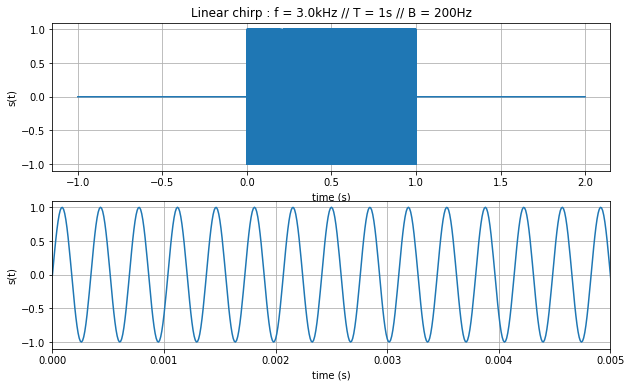

In [5]:
# plot temporal signal
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(t,s)
plt.title('Linear chirp : f = %.1fkHz // T = %ds // B = %dHz' %(f0/1000.,T,B))
plt.xlabel('time (s)')
plt.ylabel('s(t)')
plt.grid()

plt.subplot(212)
plt.plot(t,s)
plt.xlabel('time (s)')
plt.ylabel('s(t)')
plt.xlim([0.0,0.005])
plt.grid()
plt.show()

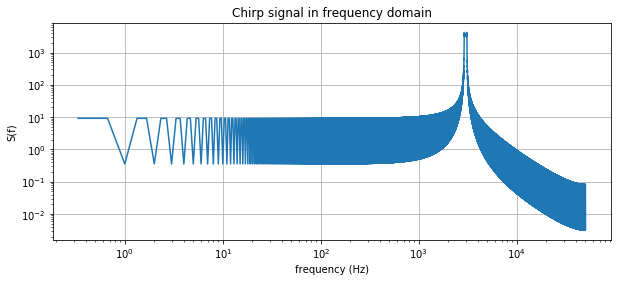

In [6]:
# Fourier transform
S = np.fft.fft(s)
freq = np.fft.fftfreq(t.shape[-1],d=t[1]-t[0])  # [0, 1/fenetre, 2/fenetre,.., Ni = 1/(2*dt), -Ni,.., -1/fenetre]
fig = plt.figure(figsize=(10,4))
ax = plt.subplot(111)
ip = np.where(freq>0)[0]
ax.plot(freq[ip], abs(S[ip]))
ax.set_yscale('log')
ax.set_xscale('log')
plt.title ('Chirp signal in frequency domain')
plt.xlabel('frequency (Hz)')
plt.ylabel('S(f)')
ax.grid()

In [7]:
# Effective bandwidth
ip = np.where(freq>0)[0]
Be2 = sum( (freq[ip] -f0)**2 * abs(S[ip])**2) /  sum( abs(S[ip])**2)
Be = np.sqrt(Be2)

In [8]:
print( "Effective bandwidth                   : Be = %.1f Hz" %Be )
print ("Approximation of rectangular spectrum : Be_approx = %.1f Hz" %(B/3.46) )

Effective bandwidth                   : Be = 63.0 Hz
Approximation of rectangular spectrum : Be_approx = 57.8 Hz


---
## Cramer Rao Bound

In [9]:
# Requested standard deviation on arrival time measurements 
e_t = 1.e-3    # (s)
c = 1500.      # celerité (m/s)
dx = e_t * c   # erreur sur la distance (m)
print("Pour une incertitude de mesure de %.e s, \
l'erreur correspondante sur la distance est de %.1f m." %(e_t, dx))

Pour une incertitude de mesure de 1e-03 s, l'erreur correspondante sur la distance est de 1.5 m.


In [10]:
# Cramer Rao bound
var1 = (e_t)**2
#Be = B/3.46            # effective bandwidth (rectangular spectrum) 
r1 = 1 / (var1 * (2*np.pi*Be)**2)
seuil = 10*np.log10(r1)
print('Le seuil de détection doit être supérieur ou égal à %.1f dB.' %seuil)

Le seuil de détection doit être supérieur ou égal à 8.0 dB.


---
## Pourcentage de détection

- Les récepteurs sont placés de 0 à 500m de profondeur (tous les 1m) et de 0 à 100km de distance (tous les 10m).

In [11]:
# pourcentage de signaux détectés - MEDITERRANNEE
for i in range (1, 5) : 
    Pos = bell.load_dict('../Dictio', 'Pos'+str(i))
    data = np.load('../Partie2_celerite_equivalente/NPY/RL_first_SSP'+str(i)+'.npy')
    RL = data.squeeze()
    accepted = np.where(RL > seuil)[0].size
    p = accepted / RL.size * 100.
    print('Méditerrannée profil n°%d : avec un seuil à %.1f dB, \
le signal reçu est détecté dans %.1f' %(i,seuil, p) + '% des cas.' )

Méditerrannée profil n°1 : avec un seuil à 8.0 dB, le signal reçu est détecté dans 99.8% des cas.
Méditerrannée profil n°2 : avec un seuil à 8.0 dB, le signal reçu est détecté dans 99.6% des cas.
Méditerrannée profil n°3 : avec un seuil à 8.0 dB, le signal reçu est détecté dans 99.5% des cas.
Méditerrannée profil n°4 : avec un seuil à 8.0 dB, le signal reçu est détecté dans 94.5% des cas.


In [12]:
# pourcentage de signaux détectés - GULF STREAM
gs = ['612_42','666_36']

for i in range (len(gs)) : 
    Pos_gs = bell.load_dict('../Dictio', 'Pos_gs_' + gs[i])
    data_gs = np.load('../Partie2_celerite_equivalente/NPY/RL_first_gs_' + gs[i] + '.npy')
    RL = data_gs.squeeze()
    accepted = np.where(RL > seuil)[0].size
    p = accepted / RL.size * 100.
    print('Gulf stream profil n°%d : avec un seuil à %.1f dB, \
le signal reçu est détecté dans %.1f' %(i+1, seuil, p) + '% des cas.' )

Gulf stream profil n°1 : avec un seuil à 8.0 dB, le signal reçu est détecté dans 99.5% des cas.
Gulf stream profil n°2 : avec un seuil à 8.0 dB, le signal reçu est détecté dans 99.4% des cas.
